<strong> Name </strong> : Alexis Jordan

## Audio Preprocessing

The purpose of this script is to preprocess our data to put it in better condition for our models. In addition to normalizing our audio clips, we will also build a dataset of diagnoses, filenames and patient id to make file extraction easier. 
This code was adapted from: 

#### Imports

In [37]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import librosa as lb
import librosa.display
import keras

In [2]:
import os

This is our patient data, we will only need to pull in patient id and disease diagnosis as the other data is not relevant to our task. 

In [3]:
patient_data = pd.read_csv('Respiratory_Sound_Database/patient_diagnosis.csv', names=['pid', 'disease'])

In [4]:
patient_data.head()

,pid,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


The following is an example of the text files that accompany each audio file. <br>
For an example file "160_1b3_A1_mc_AKGC417.txt" the formatting as follows:
1. 160 = patient id
2. 1b3 = recording index
3. Al = chest location, in this case Anterior Left
    1. Other options: Trachea (Tc), Anterior(A), Posterior (P), Lateral (L) || left (l) and right (r)
4. Acquisition Mode
    1. mc: multichannel (as opposed to sc: single channel)
5. Recording Equipment
    1. AKGC417L - AKG Microphone
    2. LittC2SE - 3M Littmann Classic II SE Stethoscope
    3. Litt3200 - 3M Litmmann 3200 Electronic Stethoscope
    4. Meditron - WelchAllyn Meditron Master Elite Electronic Stethoscope

In [13]:
df = pd.read_csv('Respiratory_Sound_Database/audio_and_txt_files/160_1b3_Al_mc_AKGC417L.txt', header=None, sep='\t', names=['start', 'end', 'cracks', 'wheezes'])

In [14]:
df.head()

,start,end,cracks,wheezes
0,1.862,5.718,0,1
1,5.718,9.725,1,1
2,9.725,13.614,0,1
3,13.614,17.671,0,1
4,17.671,19.541,0,0


In [15]:
import os
path = "Respiratory_Sound_Database/audio_and_txt_files/"
files = [s.split('.')[0] for s in os.listdir(path) if '.txt' in s]
files[:5]

['101_1b1_Al_sc_Meditron',
 '101_1b1_Pr_sc_Meditron',
 '102_1b1_Ar_sc_Meditron',
 '103_2b2_Ar_mc_LittC2SE',
 '104_1b1_Al_sc_Litt3200']

Next, we'll make a list of our files and then get the information from these files (based on the filename) and we will store this information into a dataframe along with the other information

In [16]:
def getFilenameInfo(file):
    return file.split('_')

In [17]:
getFilenameInfo('101_1b1_Al_sc_Meditron')

['101', '1b1', 'Al', 'sc', 'Meditron']

In [20]:
files_data = []

for file in files:
    data = pd.read_csv(path + file + '.txt', sep='\t', names=['start', 'end', 'cracks', 'wheezes'])
    name_data = getFilenameInfo(file)
    data['pid'] = name_data[0]
    data['mode'] = name_data[-2]
    data['filename'] = file
    files_data.append(data)

files_df = pd.concat(files_data)
files_df.reset_index()
files_df.head()

,start,end,cracks,wheezes,pid,mode,filename
0,0.036,0.579,0,0,101,sc,101_1b1_Al_sc_Meditron
1,0.579,2.450,0,0,101,sc,101_1b1_Al_sc_Meditron
2,2.450,3.893,0,0,101,sc,101_1b1_Al_sc_Meditron
3,3.893,5.793,0,0,101,sc,101_1b1_Al_sc_Meditron
4,5.793,7.521,0,0,101,sc,101_1b1_Al_sc_Meditron


In [19]:
patient_data.info()       # view the data types of our patient dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   pid      126 non-null    int64 
 1   disease  126 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


In [21]:
files_df.info()         # view the data types of our newly created dataframe

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6898 entries, 0 to 10
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   start     6898 non-null   float64
 1   end       6898 non-null   float64
 2   cracks    6898 non-null   int64  
 3   wheezes   6898 non-null   int64  
 4   pid       6898 non-null   object 
 5   mode      6898 non-null   object 
 6   filename  6898 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 431.1+ KB


In [24]:
patient_data.pid = patient_data.pid.astype('int32')     # we want to change our patient id from an object to an integer
files_df.pid = files_df.pid.astype('int32')

In [26]:
data = pd.merge(files_df, patient_data, on='pid')      # then we merge our two dataframe on patient id
data.head()

,start,end,crackles,weezels,pid,mode,filename,disease
0,0.036,0.579,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI
1,0.579,2.450,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI
2,2.450,3.893,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI
3,3.893,5.793,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI
4,5.793,7.521,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI


In [27]:
os.makedirs('csv_data')                                   # we make a new directory and file for this information
data.to_csv('csv_data/data.csv', index=False)

In [28]:
## Processing Audio Files

Utilize our start and end times to make sure that we only grab the parts of the file that contain the respiratory cycles. <br>
We'll multiply the start index by the sampling rate because the start is measured in time and the array is sampled according to the sampling rate <br>

In [29]:
def getPureSample(raw_data, start, end, sr=22050):
   
    '''
    Splits a numpy array into start and end args
    
    raw_data = numpy array of audio sample
    start = start time
    end = end time
    sr = sampling_rate
    mode = mono/stereo
    '''
    
    max_ind = len(raw_data)
    start_ind = min(int(start*sr), max_ind)
    end_ind = min(int(end*sr), max_ind)
    
    return raw_data[start_ind: end_ind]

It's super important that our images to be fed into the CNN are the same size. For this reason, the audio files must be the same size. 
<br>
As we see in the scatterplot and boxplot below, this is not currently the case. 

<AxesSubplot:ylabel='pid'>

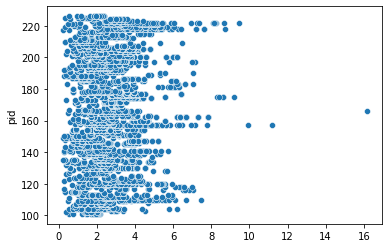

In [30]:
sns.scatterplot(x=(data.end-data.start), y = data.pid)

<AxesSubplot:>

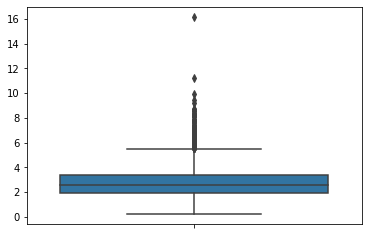

In [32]:
sns.boxplot(y=data.end-data.start)

In order to normalize the lengths, we'll add a zero pad (which is basically silence) to the file 
We'll choose a size of 6 based on the boxplot above. 

In [33]:
os.makedirs('processed_audio_files')        # make new directory

In [22]:
for index, row in data.iterrows():           
    print('Index -->', index)
    print('Data --> \n', row)
    break

Index --> 0
Data --> 
 start                        0.036
end                          1.207
cracks                           0
wheezes                          0
pid                            226
mode                            sc
filename    226_1b1_Pl_sc_LittC2SE
Name: 0, dtype: object


Librosa will be used for loading audio files <br>
Soundfile will be used to write the file to the output

In [37]:
import librosa as lb
import soundfile as sf

i,c = 0,0

for index, row in data.iterrows():
    maxLen=6
    start=row['start']
    end=row['end']
    filename = row['filename']
    
    if end-start > maxLen:
        end = start + maxLen
        
    audio_file_loc = path + filename + '.wav'
    
    if index > 0:
        
        if data.iloc[index-1]['filename'] == filename:
            i += 1
        else:
            i = 0
    
    
    filename = filename + '_' + str(i) + '.wav'
    
    save_path = 'processed_audio_files/' + filename
    c += 1
    
    audioArr,sampleRate=lb.load(audio_file_loc)
    pureSample=getPureSample(audioArr,start,end,sampleRate)
    
    #pad audio if pureSample len < max_len
    reqLen=6*sampleRate
    padded_data = lb.util.pad_center(pureSample, reqLen)
    
    sf.write(file=save_path,data=padded_data,samplerate=sampleRate)
print('Total Files Processed: ',c)

Total Files Processed:  6898


In [27]:
diagnosis = pd.read_csv('Respiratory_Sound_Database/patient_diagnosis.csv', names=['pid', 'disease'])    # we have also created a diagnosis dataframe
diagnosis.head()

,pid,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


Based on the countplot below, we see that our data is very heavily skewed to COPD which of course is not ideal

(array([ 0., 10., 20., 30., 40., 50., 60., 70.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

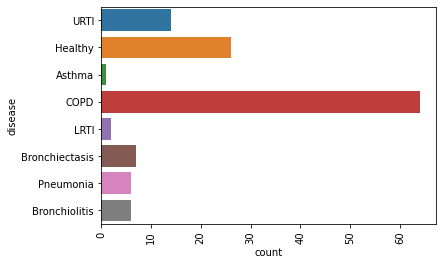

In [25]:
sns.countplot(y = diagnosis.disease)
plt.xticks(rotation=90)

In [28]:
def extractId(filename):
    return filename.split('_')[0]

In [29]:
path = 'processed_audio_files/'                                         

length=len(os.listdir(path))
index=range(length)
i=0
files_df=pd.DataFrame(index=index,columns=['pid','filename'])
for f in os.listdir(path):
    files_df.iloc[i]['pid']=extractId(f)
    files_df.iloc[i]['filename']=f
    i+=1
files_df.head()

,pid,filename
0,101,101_1b1_Al_sc_Meditron_0.wav
1,101,101_1b1_Al_sc_Meditron_1.wav
2,101,101_1b1_Al_sc_Meditron_10.wav
3,101,101_1b1_Al_sc_Meditron_11.wav
4,101,101_1b1_Al_sc_Meditron_2.wav


In [30]:
files_df.pid = files_df.pid.astype('int64')

In [31]:
data = pd.merge(files_df, diagnosis, on='pid')                  # this will be ideal to extract files during modeling
data.head()

,pid,filename,disease
0,101,101_1b1_Al_sc_Meditron_0.wav,URTI
1,101,101_1b1_Al_sc_Meditron_1.wav,URTI
2,101,101_1b1_Al_sc_Meditron_10.wav,URTI
3,101,101_1b1_Al_sc_Meditron_11.wav,URTI
4,101,101_1b1_Al_sc_Meditron_2.wav,URTI


C:\Users\alexi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'URTI'),
  Text(1, 0, 'Healthy'),
  Text(2, 0, 'Asthma'),
  Text(3, 0, 'COPD'),
  Text(4, 0, 'LRTI'),
  Text(5, 0, 'Bronchiectasis'),
  Text(6, 0, 'Pneumonia'),
  Text(7, 0, 'Bronchiolitis')])

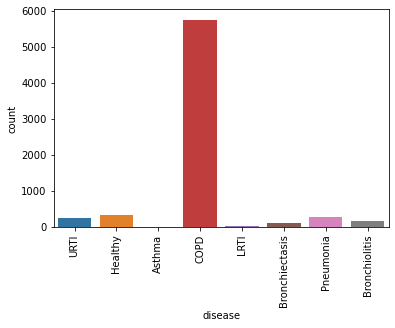

In [32]:
sns.countplot(data.disease)
plt.xticks(rotation=90)

Let's create our train and test datasets beforehand

In [33]:
from sklearn.model_selection import train_test_split
Xtrain, Xval, ytrain, yval=train_test_split(data,data.disease,stratify=data.disease,random_state=42,test_size=0.2)

In [34]:
Xtrain.disease.value_counts()/Xtrain.shape[0]

COPD              0.832910
Healthy           0.046756
Pneumonia         0.041319
URTI              0.035158
Bronchiolitis     0.023197
Bronchiectasis    0.015042
LRTI              0.004712
Asthma            0.000906
Name: disease, dtype: float64

In [35]:
Xval.disease.value_counts()/Xval.shape[0]

COPD              0.833333
Healthy           0.046377
Pneumonia         0.041304
URTI              0.035507
Bronchiolitis     0.023188
Bronchiectasis    0.015217
LRTI              0.004348
Asthma            0.000725
Name: disease, dtype: float64

[Text(0.5, 1.0, 'MFCC')]

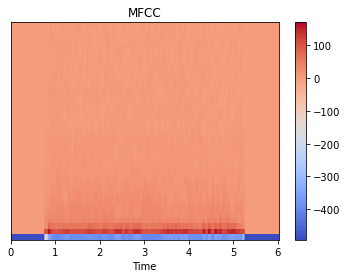

In [38]:
path='processed_audio_files/'             # sample MFCC on one of our files

import librosa.display
file=path + Xtrain.iloc[193].filename 
sound,sample_rate=lb.load(file)
mfccs = lb.feature.mfcc(y=sound, sr=sample_rate, n_mfcc=40)
fig, ax = plt.subplots()
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC')

In [57]:
Xtrain.to_csv('train.csv')                  # creating our files
Xval.to_csv('val.csv')

In [39]:
train = pd.read_csv('train.csv')
val = pd.read_csv('val.csv')
train.head()

,Unnamed: 0,pid,filename,disease
0,2562,151,151_2p3_Lr_mc_AKGC417L_4.wav,COPD
1,2536,151,151_2p2_Tc_mc_AKGC417L_2.wav,COPD
2,6893,226,226_1b1_Pl_sc_LittC2SE_5.wav,Pneumonia
3,5089,191,191_2b1_Pr_mc_LittC2SE_0.wav,Pneumonia
4,1897,138,138_1p2_Pl_mc_AKGC417L_3.wav,COPD


In [40]:
ytrain = train.disease
yval = val.disease
yval

0                COPD
1                LRTI
2             Healthy
3                COPD
4                COPD
            ...      
1375    Bronchiolitis
1376             URTI
1377             COPD
1378             COPD
1379             COPD
Name: disease, Length: 1380, dtype: object